<div style="text-align:center">
    <h1 style="text-align:center; font-size:50px; margin-bottom: 5px">Detection Rates</h1>
    <p style="text-align:center;">This notebook demonstrates how to reproduce the plots that examine the detection rates of Galactic DCOs in Wagg et al. (2021). The main plot show the detection rate for the 17 model variations and we also show a supplementary plot of the detectable <i>fraction</i>. In order to make these plots you'll need the data, which can be found <a href="https://zenodo.org/record/4699713">here</a> on Zenodo.</p>
</div>

In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import legwork
import os
import sys
sys.path.append("../../simulation/src/")
from variations import variations

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 20

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)

In [3]:
dco_types = ["BHBH", "BHNS", "NSNS"]
data_path = "../../simulation/data/"
sim_folder = data_path + "simulation/"

total_DCOs_in_MW = np.load(data_path + "total_DCO_in_MW.npy")

detections_4yr = np.load(data_path + "detections_4yr.npy")
detections_10yr = np.load(data_path + "detections_10yr.npy")
detections_only_fractions = np.load(data_path + "detections_only_fractions.npy")

# Define plotting function

In [8]:
def plot_variations(dco_type, variations, detections,
                    dotsize=200, capwidth=0.15, error_bars=[(1, "-"), (2, "dotted")],
                    xlabel="Model Variation", ylabel="LISA Detections", shadow=False,
                    yscale="log", fig=None, ax=None, show=True, limit=(1e0, 2e2)):
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, figsize=(15, 5))
    
    # work out mean and standard deviations
    medians = np.mean(detections, axis=2)[dco_types.index(dco_type)]
    errors = [scipy.stats.poisson(medians).ppf(0.5 - (0.9545 / 2)),
              scipy.stats.poisson(medians).ppf(0.5 - (0.6827 / 2)),
              scipy.stats.poisson(medians).ppf(0.5 + (0.6827 / 2)),
              scipy.stats.poisson(medians).ppf(0.5 + (0.9545 / 2))]
    
    # plot the means as points
    xticks = np.arange(len(variations)).astype(int)
    colours = np.array([variations[v]["colour"] for v in range(len(variations))], dtype="object")
    ax.scatter(xticks, medians, s=dotsize, color=colours, zorder=5)
    
    zeros = medians == 0.0
    ax.scatter(xticks[zeros], np.repeat(limit[0] * 1.1, len(medians[zeros])), s=dotsize,
               color=colours[zeros], zorder=5, marker="X")
    
    for v in range(len(variations)):
        if medians[v] != 0:
            for width, style, indices in [(4, "-", [1, 2]), (2, "dotted", [0, 3])]:

                for index in indices:
                    # plot line up to error (adjust width and style)
                    ax.plot([xticks[v], xticks[v]], [medians[v], max(errors[index][v], limit[0])],
                            color=colours[v], linewidth=width, linestyle=style)

                    if errors[index][v] < limit[0]:
                        ax.annotate("", xy=(xticks[v], limit[0]), xytext=(xticks[v], limit[0] * 1.01),
                                    arrowprops=dict(arrowstyle="->", linewidth=width, color=colours[v]), zorder=10)
                    else:
                        # plot caps on top of error bars
                        ax.plot([xticks[v] - capwidth, xticks[v] + capwidth],
                                [errors[index][v], errors[index][v]],
                                color=colours[v], linewidth=width, linestyle=style)

    ax.set_xticks(xticks)
    ax.set_xticklabels([variations[v]["short"] for v in range(len(variations))])
    
    ax.set_xlim(xticks[0] - 0.5, xticks[-1] + 0.5)
    
    ax.set_yscale(yscale)
    
    xlims = ax.get_xlim()
    
    if shadow:
        ax.fill_between(xlims, means[0] - stds[0], means[0] + stds[0], color="grey", alpha=0.1, zorder=-1)
        ax.fill_between(xlims, means[0] - 2 * stds[0], means[0] + 2 * stds[0], color="grey", alpha=0.1, zorder=-1)

    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=fs)
        
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=fs)

    ax.tick_params(axis="both", which="major", labelsize=fs, length=10)
    ax.tick_params(axis="both", which="minor", labelsize=fs, length=5)

    ax.annotate(dco_type, xy=(0.015, 0.96), xycoords="axes fraction", fontsize=fs,
                bbox=dict(boxstyle="round", fc="white", ec="none", pad=0.0))

    ax.grid(axis="y", which="major", lw=1.5, linestyle="--")
    ax.grid(axis="y", which="minor", lw=0.3)
    
    ax.set_ylim(limit)
    
    if show:
        plt.show()
    return fig, ax

# Overall detection rates

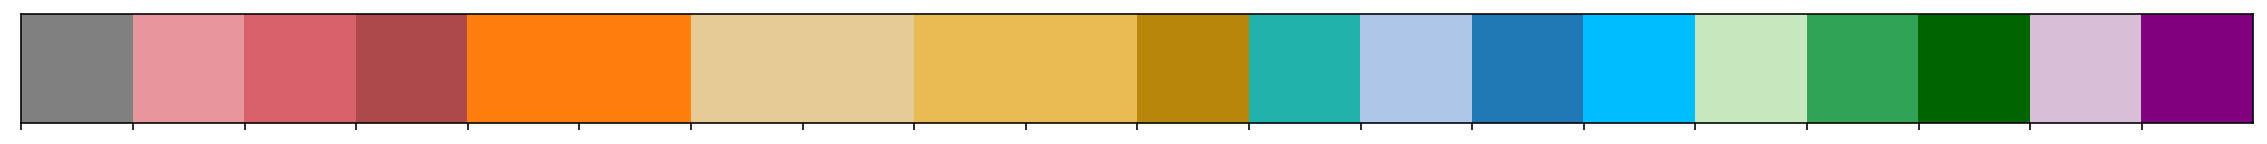

In [5]:
colours = [variations[v]["colour"] for v in range(len(variations))]
sns.palplot(colours)

# Detectable fraction

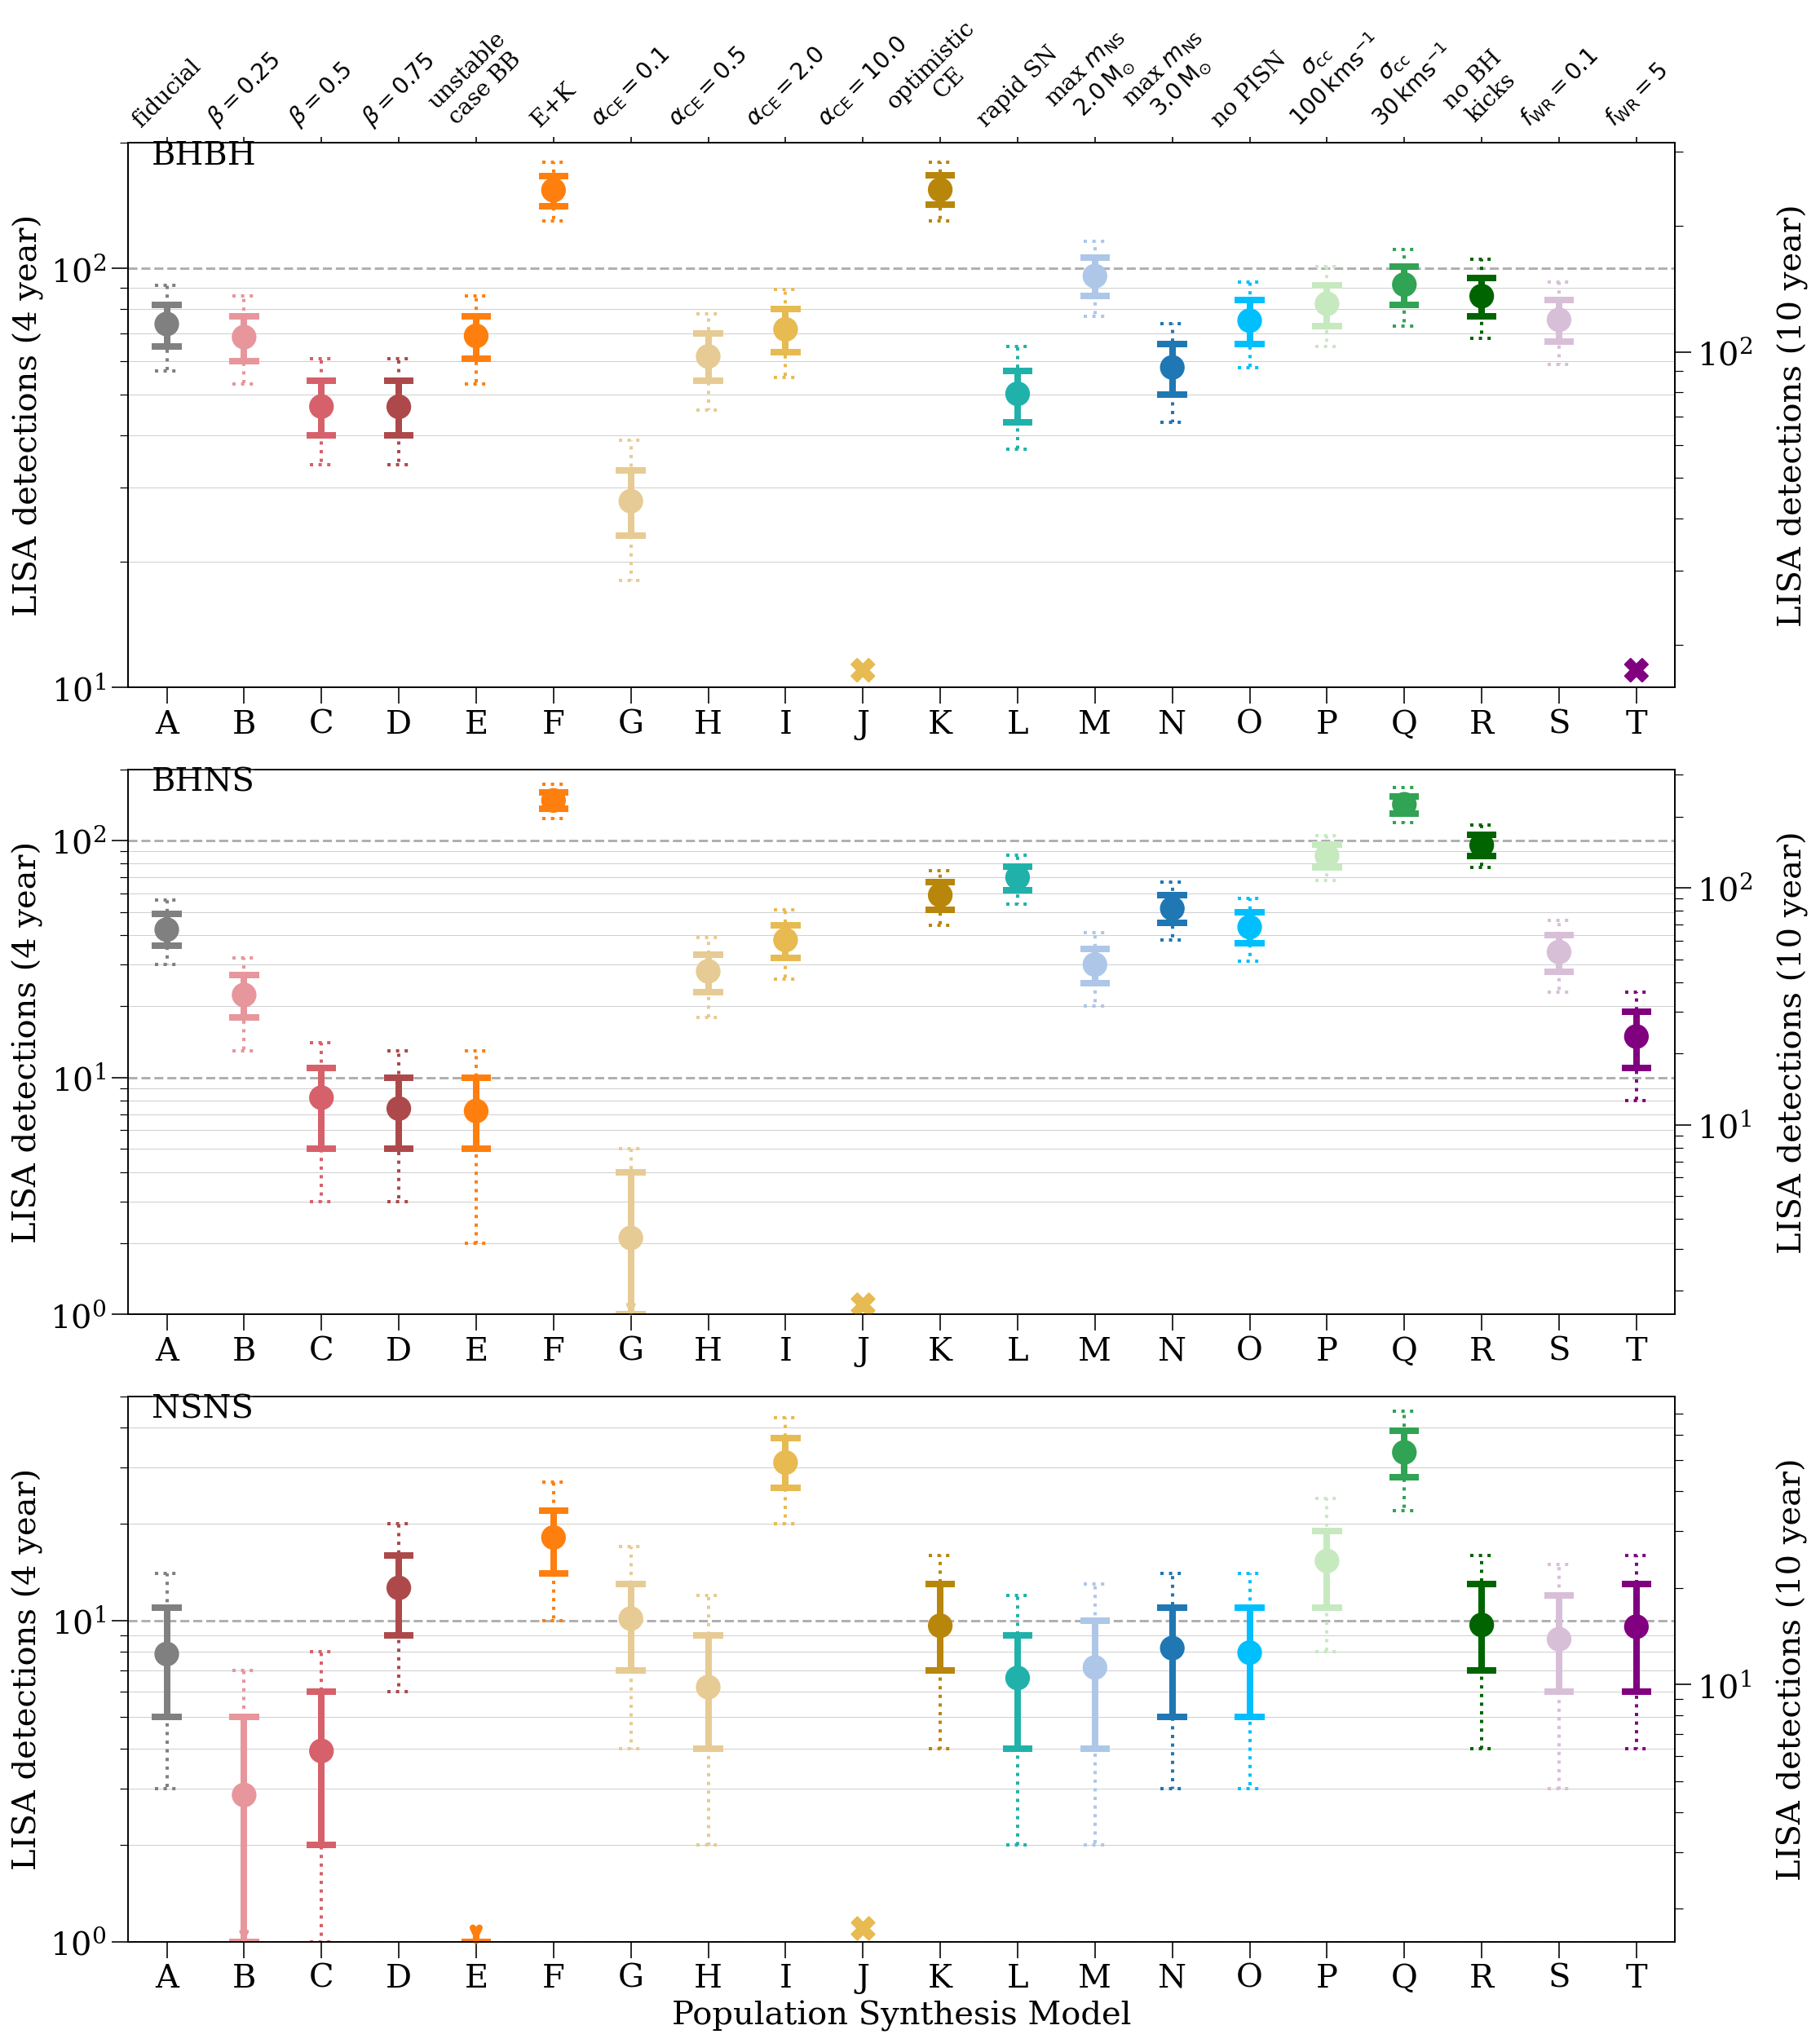

In [9]:
fig, axes = plt.subplots(3, figsize=(17, 20.3))
fig.subplots_adjust(hspace=0.15)

limits = {
    "BHBH": (1e1, 2e2),
    "BHNS": (1e0, 2e2),
    "NSNS": (1e0, 5e1)
}

for ax, dco_type in zip(axes, dco_types):
    plot_variations(dco_type, variations, detections_4yr,
                    xlabel=None, ylabel="LISA detections (4 year)",
                    fig=fig, ax=ax, show=False, yscale="log", limit=limits[dco_type])
    
    right_ax = ax.twinx()
    right_ax.set_ylim(tuple(np.array(ax.get_ylim()) * np.sqrt(10 / 4)))
    right_ax.set_yscale("log")
    right_ax.set_ylabel("LISA detections (10 year)", labelpad=15)
    right_ax.tick_params(axis="both", which="major", labelsize=fs, length=10)
    right_ax.tick_params(axis="both", which="minor", labelsize=fs, length=5)
    
top_ax = axes[0].twiny()
top_ax.set_xticks(axes[0].get_xticks())
top_ax.set_xlim(axes[0].get_xlim())
top_ax.set_xticklabels([variations[v]["med"] for v in range(len(variations))], rotation=45, fontsize=0.7*fs)

axes[-1].set_xlabel("Population Synthesis Model", fontsize=fs)

# plt.savefig("../figures/3_dco_detections.pdf", format="pdf", bbox_inches="tight")
# plt.savefig("../figures/dco_detections.png", format="png", dpi=300, bbox_inches="tight")
    
plt.show()

# Detection rate table

In [6]:
for i in range(len(variations)):
    table_line = variations[i]["short"] + " & " + variations[i]["long"]
    for detection in [detections_4yr]:
        for j in range(len(detection)):
            mean = np.mean(detection[j][i])
            low, high = scipy.stats.poisson(mean).ppf(0.5 - (0.6827 / 2)),\
                scipy.stats.poisson(mean).ppf(0.5 + (0.6827 / 2)),
            
            lower = mean - low
            upper = high - mean
            table_line += r" & \confinv{" + "{:.1f}".format(mean) + "}{" \
                        + "{:.1f}".format(lower) + "}{" \
                        + "{:.1f}".format(upper) + "}"
    table_line += "\\\\"
    print(table_line)

A & Fiducial & \confinv{73.7}{8.7}{8.3} & \confinv{42.1}{6.1}{6.9} & \confinv{7.9}{2.9}{3.1}\\
B & Fixed mass transfer efficiency of $\beta=0.25$ & \confinv{68.6}{8.6}{8.4} & \confinv{22.3}{4.3}{4.7} & \confinv{2.9}{1.9}{2.1}\\
C & Fixed mass transfer efficiency of $\beta=0.5$ & \confinv{46.8}{6.8}{7.2} & \confinv{8.2}{3.2}{2.8} & \confinv{3.9}{1.9}{2.1}\\
D & Fixed mass transfer efficiency of $\beta=0.75$ & \confinv{46.8}{6.8}{7.2} & \confinv{7.4}{2.4}{2.6} & \confinv{12.7}{3.7}{3.3}\\
E & Case BB mass transfer is always unstable & \confinv{69.0}{8.0}{8.0} & \confinv{7.2}{2.2}{2.8} & \confinv{0.2}{0.2}{0.8}\\
F & Model E + Model K & \confinv{153.8}{12.8}{12.2} & \confinv{147.8}{11.8}{12.2} & \confinv{18.2}{4.2}{3.8}\\
G & CE efficiency $\alpha = 0.1$ & \confinv{27.8}{4.8}{5.2} & \confinv{2.1}{1.1}{1.9} & \confinv{10.2}{3.2}{2.8}\\
H & CE efficiency $\alpha = 0.5$ & \confinv{61.7}{7.7}{8.3} & \confinv{28.1}{5.1}{4.9} & \confinv{6.2}{2.2}{2.8}\\
I & CE efficiency $\alpha = 2.0$ & \confi